In [154]:
#import standard modules
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from imp import reload
#import EBTEL tools
two_fluid_root = '/home/wtb2/Documents/EBTEL_analysis/src/'
import sys
sys.path.append(two_fluid_root)
import ebtel_configure as ebc
import ebtel_run as ebr
import ebtel_plot as ebp
reload(ebc)
reload(ebr)
reload(ebp)

/opt/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'ebtel_plot' from '/home/wtb2/Documents/EBTEL_analysis/src/ebtel_plot.py'>

# EBTEL Heating Sandbox

Here, I'm testing whether specifying the range of my power-law distribution allows me to properly constrain the time-averaged heating rate $H_n$.

In [155]:
#specify constants
tau = 100.0
loop_length = 40.0e+8
area = 1.0e+14
tpeak = 4.0e+6
total_time = 8.0e+4
delta = 10.0
const = {'tau':tau,'loop_length':loop_length,'area':area,'tpeak':tpeak,'total_time':total_time,'delta':delta}
#additional parameters
alpha = -1.5
t_wait = np.arange(250,5250,250)

In [156]:
#some functions
def pl_dist(a0,a1,alpha,x):
    return ((a1**(alpha+1) - a0**(alpha+1))*x + a0**(alpha+1))**(1/(alpha+1))
def time_averaged_heating_rate(L,tpeak):
    kappa = 2.0e-7
    return kappa*tpeak**(3.5)/L**2
def mean_energy(const,tn):
    hn = time_averaged_heating_rate(const['loop_length'],const['tpeak'])
    return 2.0*hn*const['loop_length']*const['area']*(const['tau'] + tn)
def min_energy(qmean,delta):
    return qmean*2.0/(delta-1.0) 

Now, for each value of $T_n$, construct a distribution whose bounds are specified such that $H_n$ is constant across $T_n$ and specified such that enough energy is being dumped in to maintain a peak temperature $T_{\mathrm{peak}}$.

In [157]:
wait_time_distributions = []
for tw in t_wait:
    #calculate number of events
    n = int(np.ceil(const['total_time']/(const['tau'] + tw)))
    #calculate bounds
    a0 = min_energy(mean_energy(const,tw),const['delta'])/(const['loop_length']*const['area']*const['tau'])
    a1 = a0*const['delta']
    #calculate the distribution
    wait_time_distributions.append(pl_dist(a0,a1,alpha,np.random.rand(n)))

Let's check what the time-averaged heating rate should be for our specified conditions in order to keep our plasma at an equilibrium temperature of $T_{\mathrm{peak}}$ and then plot the resulting values for our distributions constructed according to our constraint on $Q_{\mathrm{min}}$.

In [158]:
hn_target = time_averaged_heating_rate(const['loop_length'],const['tpeak'])
print( "The time-averaged heating rate for L=%.1f Mm and T_peak=%.1f MK is %.5f"%(const['loop_length']/1.0e+8,const['tpeak']/1.0e+6,hn_target))

The time-averaged heating rate for L=40.0 Mm and T_peak=4.0 MK is 0.00160


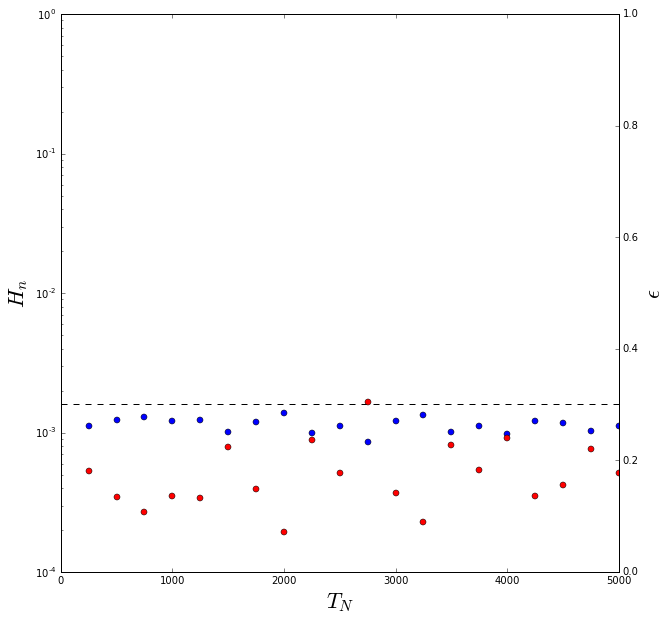

In [159]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
error_axis = ax.twinx()
for i in range(len(t_wait)):
    hn_tw = const['tau']/2.0*np.sum(wait_time_distributions[i])/const['total_time']
    ax.plot(t_wait[i],hn_tw,'bo')
    error_axis.plot(t_wait[i],np.fabs(hn_tw - hn_target)/np.fabs(hn_tw + hn_target),'ro')
ax.axhline(y=time_averaged_heating_rate(const['loop_length'],const['tpeak']),color='k',linestyle='--')
ax.set_xlabel(r'$T_N$',fontsize=22)
ax.set_ylabel(r'$H_n$',fontsize=22)
error_axis.set_ylabel(r'$\epsilon$',fontsize=22)
ax.set_ylim([0.0001,1.0])
error_axis.set_ylim([0,1])
ax.set_yscale('log')
plt.show()

Let's compare this to the case where we dont' attempt to constrain the heating at all.

In [160]:
wait_time_distributions_no_constraint= []
for tw in t_wait:
    #calculate number of events
    n = int(np.ceil(const['total_time']/(const['tau'] + tw)))
    #calculate bounds
    a0 = 1.0e+23/(const['loop_length']*const['area']*const['tau'])
    a1 = a0*const['delta']
    #calculate the distribution
    wait_time_distributions_no_constraint.append(pl_dist(a0,a1,alpha,np.random.rand(n)))

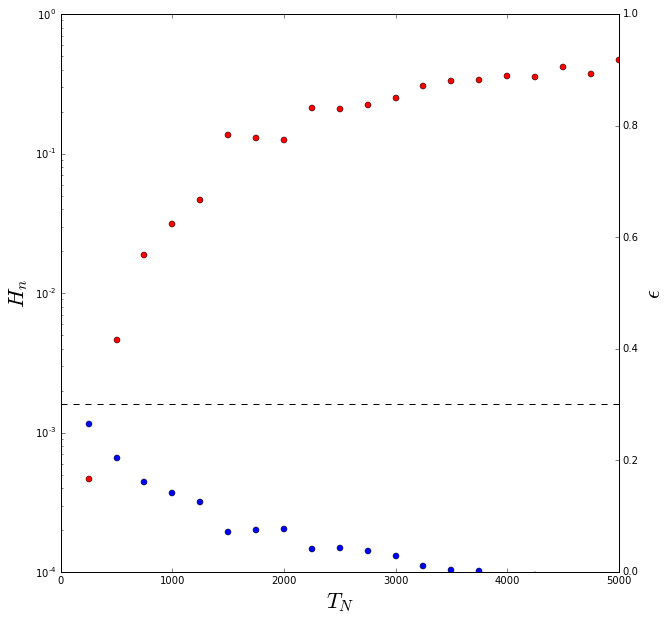

In [161]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
error_axis = ax.twinx()
for i in range(len(t_wait)):
    hn_tw = const['tau']/2.0*np.sum(wait_time_distributions_no_constraint[i])/const['total_time']
    ax.plot(t_wait[i],hn_tw,'bo')
    error_axis.plot(t_wait[i],np.fabs(hn_tw - hn_target)/np.fabs(hn_tw + hn_target),'ro')
ax.axhline(y=hn_target,color='k',linestyle='--')
ax.set_xlabel(r'$T_N$',fontsize=22)
ax.set_ylabel(r'$H_n$',fontsize=22)
error_axis.set_ylabel(r'$\epsilon$',fontsize=22)
ax.set_ylim([0.0001,1.0])
error_axis.set_ylim([0,1])
ax.set_yscale('log')
plt.show()

Obviously, the case where we attempt to constrain the range of our distribution yields much better results in terms of consistency across our range of $T_N$ values as well as matching our target $H_n$ value as compared to our current method which makes no attempt to maintain constant time-averaged heating rate. However, even in the case of varying $Q_{\mathrm{min}}$, we can see that we are still off target by a factor of 2-3 in some cases. This is most likely due to our poor estimate of $Q_{\mathrm{min}}$.

## Improved Estimates of $Q_{\mathrm{min}}$

Recall that we can calculate the mean of our power-law distribution even for $\alpha\le2$ using a Monte-Carlo approach provided we specify the bounds $a,b$. Thus, we want to find $a$ (with $b=\delta a$) such that $$\langle Q\rangle - \frac{a(\delta - 1)}{\mathcal{N}}\sum_{i=1}^{\mathcal{N}}x_ip(x_i)=0$$where $\langle Q\rangle$ is the mean energy per nanoflare as specified by $H_n$ and $T_N$, $\mathcal{N}$ is the number of points uniformly distributed on $x_i\in[a,\delta a]$, and $p(x)$ is our power-law relation. 

By coming up with a value $a$ which satisfies this relation, we will have an improved calculation of $Q_{\mathrm{min}}$ and thus better constrain $H_i$ such that the $H_n=\tau/2\sum_{i=1}^NH_i/T_{\mathrm{total}}$.

In [162]:
#monte-carlo integrator function
def monte_carlo_integrator(N,f,**kwargs):
    #generate points in the given range
    np.random.seed()
    points = (kwargs['b'] - kwargs['a'])*np.random.rand(N) + kwargs['a']
    
    #calculate the average
    f_sum = 0.0
    for p in points:
        f_sum = f_sum + f(p,**kwargs)
    f_mean = f_sum/N
    
    #return total answer
    return (kwargs['b'] - kwargs['a'])*f_mean
#power-law mean function
def pl_mean(x,**kwargs):
    #define coefficient
    C = (1.0 - kwargs['alpha'])/(kwargs['b']**(1.0-kwargs['alpha']) - kwargs['a']**(1.0-kwargs['alpha']))
    #define power-law function
    f = C*x**(-kwargs['alpha'])
    #return the mean integrand
    return x*f

Define the function that we are trying to find the zero of.

In [163]:
#function to which we will apply bisection or root finder method
def f_zero(a,**kwargs):
    #define dictionary
    const = kwargs['const']
    #get target mean value
    q_mean = mean_energy(const,kwargs['tn'])/(const['loop_length']*const['area']*const['tau'])
    #set up monte-carlo function
    mc_mean = monte_carlo_integrator(kwargs['n_mc'],pl_mean,a=a,b=const['delta']*a,alpha=kwargs['alpha'])
    return q_mean - mc_mean

Now, define the bisection method.

In [164]:
def bisection(a,b,f,options,**kwargs):
    """Bisection method for interval (a,b) as applied to a monotonically increasing (or decreasing) function f on (a,b)"""
    
    #First guess for root value
    c = a + (b - a)/2
    
    #Evaluate function at first guess
    f_guess = f(c,**kwargs)
    
    #Initialize the counter
    count = 0
    
    #Initialize lists of endpoints and roots
    a_list = [a]
    b_list = [b]
    c_list = [c]
    
    #Begin iteration
    while(count<options['max_count'] and np.fabs(f_guess)>options['tol']):
        #Output iteration and endpoints
        print( "Iteration %d, Endpoints (%e,%e)"%(count,a,b))
        #print "f(%.3e) = %.3e"%(c,f_guess)
        
        #Check relative sign
        if f_guess*f(a,**kwargs)>0:
            #advance left endpoint
            a=c
        elif f_guess*f(a,**kwargs)<0:
            #advance right endpoint
            b=c
        else:
            #case where f(c)==0
            print( "f(c) == 0 exactly. Breaking out of loop.")
            break
            
        #update root value guess
        c = a + (b-a)/2
        
        #evaluate function at current guess
        f_guess = f(c,**kwargs)
        
        #save a,b,c values
        a_list.append(a)
        b_list.append(b)
        c_list.append(c)
        
        #update the counter
        count = count + 1
        
    #check to see whether we succeded
    if count < options['max_count'] or np.fabs(f_guess) < options['tol']:
        #print final zero approximation
        print("Value of the function at approximate zero is f(c=%f)=%f"%(c,f_guess))
    
        #return lists of a,b,c
        return a_list,b_list,c_list
    else:
        #tell the user that the bisection failed
        print ("Unable to perform bisection with max number of tries = %d and error tolerance %.4f"%(options['max_count'],options['tol']))

To make an estimation of our bounds for the bisection method, we need to find the value of $a$ that minimizes the $|\langle Q\rangle - \langle Q\rangle_{\mathrm{MC}}|$. For each waiting time $T_N$, we will calculate our target mean event energy, $\langle Q\rangle$, and then apply the bisection method to find the needed $Q_{\mathrm{min}}$. Then a distribution is constructed and an actual value of $H_n$ is found which can be compared to our target value needed to keep our loop at an equilibrium temperature of $T_{\mathrm{peak}}$.

In [165]:
#loop over wait times, calculate qmin, construct distribution
wait_time_distributions_improved = []
for tw in t_wait:
    #calculate number of events
    n = int(np.ceil(const['total_time']/(const['tau'] + tw)))
    #Use estimate to find sensible bounds
    a_guess = min_energy(mean_energy(const,tw),const['delta'])/(const['loop_length']*const['area']*const['tau'])
    b_guess = 1.1*a_guess
    a_guess = 0.3*a_guess
    #apply bisection method
    opt = {'max_count':100,'tol':1e-1}
    dummy,dummy,a0 = bisection(a_guess,b_guess,f_zero,opt,const=const,alpha=alpha,tn=tw,n_mc=1.0e+4)
    #get best value from bisection
    a0 = a0[-1]
    a1 = a0*const['delta']
    #construct distribution
    wait_time_distributions_improved.append(pl_dist(a0,a1,alpha,np.random.rand(n)))

Value of the function at approximate zero is f(c=0.001742)=-0.001344
Value of the function at approximate zero is f(c=0.002987)=-0.002048
Value of the function at approximate zero is f(c=0.004231)=-0.002515
Value of the function at approximate zero is f(c=0.005476)=-0.004580
Value of the function at approximate zero is f(c=0.006720)=-0.005355
Value of the function at approximate zero is f(c=0.007964)=-0.005607
Value of the function at approximate zero is f(c=0.009209)=-0.006965
Value of the function at approximate zero is f(c=0.010453)=-0.006969
Value of the function at approximate zero is f(c=0.011698)=-0.007996
Value of the function at approximate zero is f(c=0.012942)=-0.007878
Value of the function at approximate zero is f(c=0.014187)=-0.009725
Value of the function at approximate zero is f(c=0.015431)=-0.012051
Value of the function at approximate zero is f(c=0.016676)=-0.013119
Value of the function at approximate zero is f(c=0.017920)=-0.011911
Value of the function at approxima

/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


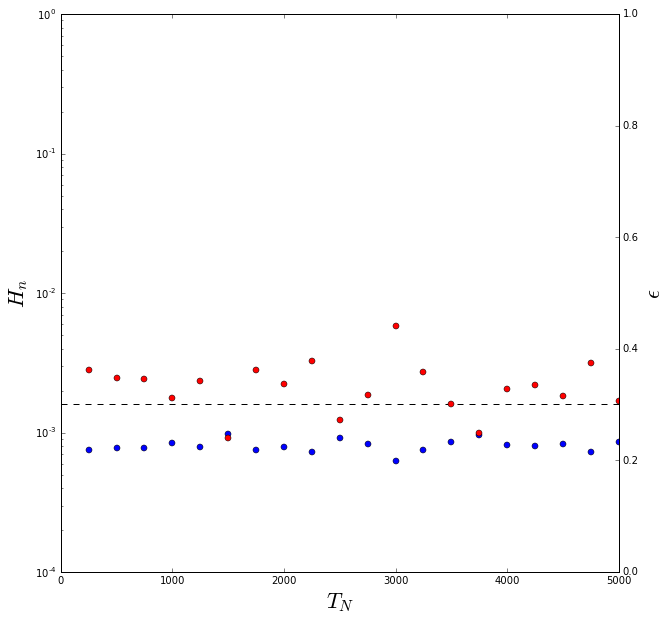

In [166]:
hn_target = time_averaged_heating_rate(const['loop_length'],const['tpeak'])
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
error_axis = ax.twinx()
for i in range(len(t_wait)):
    hn_tw = const['tau']/2.0*np.sum(wait_time_distributions_improved[i])/const['total_time']
    ax.plot(t_wait[i],hn_tw,'bo')
    error_axis.plot(t_wait[i],np.fabs(hn_tw - hn_target)/np.fabs(hn_tw + hn_target),'ro')
ax.axhline(y=hn_target,color='k',linestyle='--')
ax.set_xlabel(r'$T_N$',fontsize=22)
ax.set_ylabel(r'$H_n$',fontsize=22)
error_axis.set_ylabel(r'$\epsilon$',fontsize=22)
ax.set_ylim([0.0001,1.0])
error_axis.set_ylim([0,1])
ax.set_yscale('log')
plt.show()

So even using this supposedly improved (but much slower!) method results in underestimation and even incurs more error than our quick and dirty estimation. 

We seemed to have picked up an extra factor of two in our derivation of the resulting lower bound on the distribution. Our new expression for the bounds on our distribution is given by $$Q_{\mathrm{min}}=\frac{2H_nLA(T_N+\tau)}{\delta-1}.$$Now, we can construct our distribution of event energies. 

In [167]:
wait_time_distributions = []
alpha = -1.5
const['loop_length'] = 60.0e+8
for tw in t_wait:
    #calculate number of events
    n = int(np.ceil(const['total_time']/(const['tau'] + tw)))
    #calculate bounds
    a0 = 3.0*time_averaged_heating_rate(const['loop_length'],const['tpeak'])*const['loop_length']*const['area']*(const['tau'] + tw)/(const['delta']-1.0)
    a1 = a0*const['delta']
    #calculate the distribution
    wait_time_distributions.append(pl_dist(a0,a1,alpha,np.random.rand(n)))

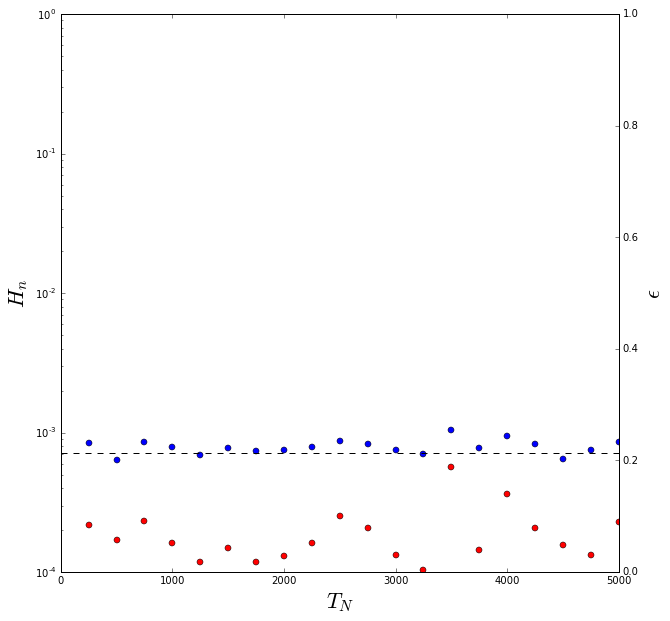

In [168]:
hn_target = time_averaged_heating_rate(const['loop_length'],const['tpeak'])
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
error_axis = ax.twinx()
for i in range(len(t_wait)):
    hn_tw = np.sum(wait_time_distributions[i])/const['total_time']/const['loop_length']/const['area']
    ax.plot(t_wait[i],hn_tw,'bo')
    error_axis.plot(t_wait[i],np.fabs(hn_tw - hn_target)/np.fabs(hn_tw + hn_target),'ro')
ax.axhline(y=hn_target,color='k',linestyle='--')
ax.set_xlabel(r'$T_N$',fontsize=22)
ax.set_ylabel(r'$H_n$',fontsize=22)
error_axis.set_ylabel(r'$\epsilon$',fontsize=22)
ax.set_ylim([0.0001,1.0])
error_axis.set_ylim([0,1])
ax.set_yscale('log')
plt.show()

If $\alpha>2$, we can make a (hopefully) more accurate estimate of $Q_{\mathrm{min}}$.

In [169]:
wait_time_distributions = []
alpha = -2.5
const['loop_length'] = 20.0e+8
for tw in t_wait:
    #calculate number of events
    n = int(np.ceil(const['total_time']/(const['tau'] + tw)))
    #calculate bounds
    coeff = (alpha + 2.0)/(alpha + 1.0)*(const['delta']**(alpha + 1.0) - 1.0)/(const['delta']**(alpha + 2.0) - 1.0)
    a0 = coeff*time_averaged_heating_rate(const['loop_length'],const['tpeak'])*const['loop_length']*const['area']*(const['tau'] + tw)
    a1 = a0*const['delta']
    #calculate the distribution
    wait_time_distributions.append(pl_dist(a0,a1,alpha,np.random.rand(n)))

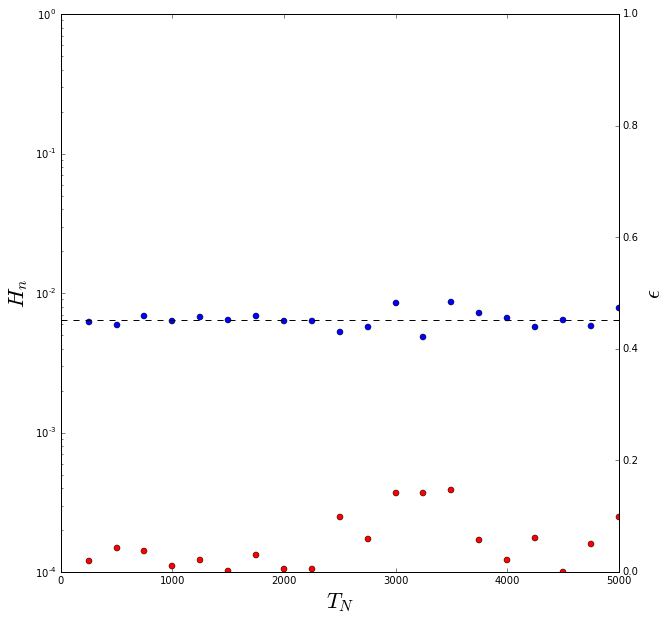

In [170]:
hn_target = time_averaged_heating_rate(const['loop_length'],const['tpeak'])
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
error_axis = ax.twinx()
for i in range(len(t_wait)):
    hn_tw = np.sum(wait_time_distributions[i])/const['total_time']/const['loop_length']/const['area']
    ax.plot(t_wait[i],hn_tw,'bo')
    error_axis.plot(t_wait[i],np.fabs(hn_tw - hn_target)/np.fabs(hn_tw + hn_target),'ro')
ax.axhline(y=hn_target,color='k',linestyle='--')
ax.set_xlabel(r'$T_N$',fontsize=22)
ax.set_ylabel(r'$H_n$',fontsize=22)
error_axis.set_ylabel(r'$\epsilon$',fontsize=22)
ax.set_ylim([0.0001,1.0])
error_axis.set_ylim([0,1])
ax.set_yscale('log')
plt.show()

Now, compare coefficients on estimates of $Q_{\mathrm{min}}$ which we write as $$\xi_{\alpha\le2}=\frac{2}{\delta - 1},\quad\xi_{\alpha>2}=\frac{\alpha+2}{\alpha+1}\frac{\delta^{\alpha + 1}-1}{\delta^{\alpha + 2}-1}.$$

In [171]:
def xi_rough(delta):
    return 2.0/(delta - 1)
def xi_exact(delta,alpha):
    return (alpha + 2.0)/(alpha + 1.0)*(delta**(alpha + 1.0) - 1.0)/(delta**(alpha + 2.0) - 1.0)
def xi_exact_lhopital(delta,alpha):
    numer = delta**(alpha+1.0)*(1.0 + np.log(delta)*(alpha + 2.0)) - 1.0
    denom = delta**(alpha+2.0)*(1.0 + np.log(delta)*(alpha + 1.0)) - 1.0
    return numer/denom

In [172]:
#set delta to one decade
delta=10.0
#compare difference for alpha=2.5
alpha = -2.5

In [173]:
print ("Rough estimate for xi for alpha=%.1f is %.3f"%(alpha,xi_rough(delta)))
print ("Exact estimate for xi for alpha=%.1f is %.3f"%(alpha,xi_exact(delta,alpha)))

Rough estimate for xi for alpha=-2.5 is 0.222
Exact estimate for xi for alpha=-2.5 is 0.472


In [174]:
alpha = -2.0
print ("Rough estimate for xi for alpha=%.1f is %.3f"%(alpha,xi_rough(delta)))
print ("Exact estimate for xi for alpha=%.1f is %.3f"%(alpha,xi_exact_lhopital(delta,alpha)))

Rough estimate for xi for alpha=-2.0 is 0.222
Exact estimate for xi for alpha=-2.0 is 0.391


Now, let's combine these two expressions and compute the resulting $H_n$ for some power-law distributions.

In [175]:
def qmin_coefficient(delta,alpha):
    if alpha == -2.0:
        numer = delta**(alpha+1.0)*(1.0 + np.log(delta)*(alpha + 2.0)) - 1.0
        denom = delta**(alpha+2.0)*(1.0 + np.log(delta)*(alpha + 1.0)) - 1.0
        return numer/denom
    else:
        return (alpha + 2.0)/(alpha + 1.0)*(delta**(alpha + 1.0) - 1.0)/(delta**(alpha + 2.0) - 1.0)

In [176]:
wait_time_distributions = []
alphas = [-1.5,-2.0,-2.5]
const['loop_length'] = 60.0e+8
hn_target = time_averaged_heating_rate(const['loop_length'],const['tpeak'])
for a in alphas:
    wait_time_distributions_temp = []
    for tw in t_wait:
        #calculate number of events
        n = int(np.ceil(const['total_time']/(const['tau'] + tw)))
        #calculate bounds
        coeff = qmin_coefficient(const['delta'],a)
        a0 = coeff*time_averaged_heating_rate(const['loop_length'],const['tpeak'])*const['loop_length']*const['area']*(const['tau'] + tw)
        a1 = a0*const['delta']
        #calculate the distribution
        wait_time_distributions_temp.append(pl_dist(a0,a1,a,np.random.rand(n)))
    wait_time_distributions.append(wait_time_distributions_temp)

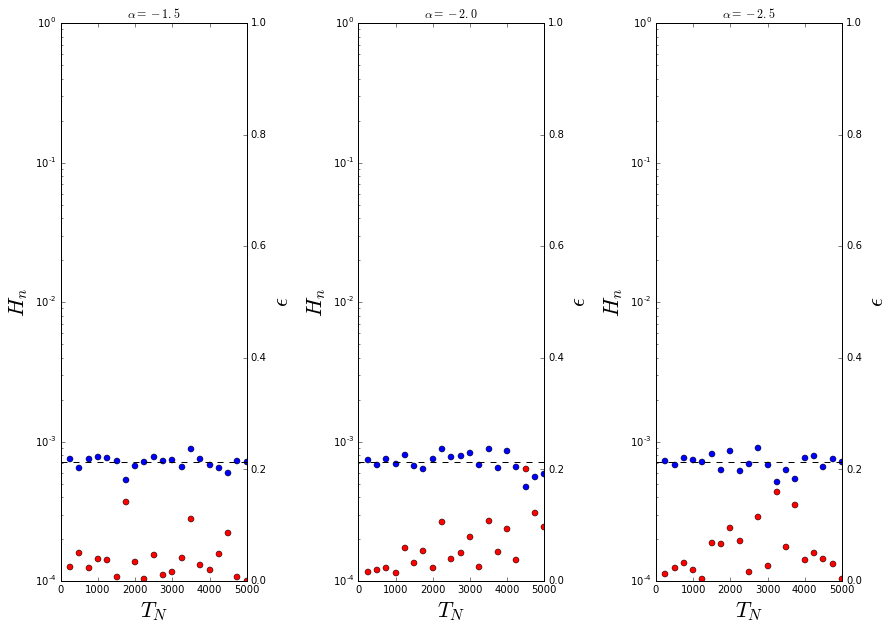

In [177]:
fig,ax = plt.subplots(1,len(alphas),figsize=(14,10))
plt.subplots_adjust(wspace=0.6)
for i in range(len(alphas)):
    error_axis = ax[i].twinx()
    for j in range(len(t_wait)):
        hn_tw = np.sum(wait_time_distributions[i][j])/const['total_time']/const['loop_length']/const['area']
        ax[i].plot(t_wait[j],hn_tw,'bo')
        error_axis.plot(t_wait[j],np.fabs(hn_tw - hn_target)/np.fabs(hn_tw + hn_target),'ro')
    ax[i].axhline(y=hn_target,color='k',linestyle='--')
    ax[i].set_xlabel(r'$T_N$',fontsize=22)
    ax[i].set_ylabel(r'$H_n$',fontsize=22)
    error_axis.set_ylabel(r'$\epsilon$',fontsize=22)
    ax[i].set_ylim([0.0001,1.0])
    error_axis.set_ylim([0,1])
    ax[i].set_yscale('log')
    ax[i].set_title(r'$\alpha=%.1f$'%alphas[i])

## Testing with two-fluid EBTEL model

Now, we will conduct a few test EBTEL two-fluid runs with these newly modified heating amplitudes to see how the model performs. First we need to configure the input file. We will use the first waiting time that seems to have failed on previous runs, $T_N=1500$ s with $\alpha=-1.5$ and $L=20.0$ Mm where we are heating the electrons.

In [178]:
#build input dictionary
#Configure all static dictionary options
config_dict = {'usage_option':'dem','rad_option':'rk','dem_option':'new','heat_flux_option':'limited','solver':'euler','ic_mode':'st_eq','print_plasma_params':'True'}
config_dict['output_file'] = '/Users/willbarnes/Documents/Rice/Research/research_notebook/ebtel_data/const_heating_rate_testing'
config_dict['heat_species'] = 'electron'
config_dict['loop_length'] = 20.0
config_dict['total_time'] = 80000
config_dict['tau'] = 1.0
config_dict['rka_error'] = 1.0e-6
config_dict['index_dem'] = 451
config_dict['sat_limit'] = 1.0#0.166667
config_dict['h_back'] = 3.4e-6
config_dict['sample_rate'] = 1
config_dict['heating_shape'] = 'triangle'
config_dict['t_start_switch'] = 'file'
config_dict['t_end_switch'] = 'file'
config_dict['T0'] = 1.0e+6
config_dict['n0'] = 1.0e+8
config_dict['t_start'] = 100.0
config_dict['t_pulse_half'] = 50.0
config_dict['mean_t_start'] = 1000
config_dict['std_t_start'] = 1000

In [179]:
def make_time_arrays(conf_dict,ti):
    conf_dict['num_events'] = int(np.ceil(conf_dict['total_time']/(2.0*conf_dict['t_pulse_half'] + ti)))
    conf_dict['start_time_array'],conf_dict['end_time_array'] = np.empty(conf_dict['num_events']),np.empty(conf_dict['num_events'])
    for i in range(conf_dict['num_events']):
        conf_dict['start_time_array'][i] = i*(2.0*conf_dict['t_pulse_half'] + ti)
        conf_dict['end_time_array'][i] = conf_dict['start_time_array'][i] + 2.0*conf_dict['t_pulse_half']
        
    return conf_dict

In [180]:
#configure number of events, start times, and end times
ti = 5000
config_dict = make_time_arrays(config_dict,ti)

In [181]:
#configure heating amplitude options for either a power-law or uniform situation
config_dict['alpha'] = -1.5
delta = 10.0
tpeak = 4.0e+6
hn = time_averaged_heating_rate(config_dict['loop_length']*1.0e+8,tpeak)
coeff = qmin_coefficient(delta,config_dict['alpha'])
config_dict['amp0'] = coeff*hn*(2.0*config_dict['t_pulse_half'] + ti)/config_dict['t_pulse_half']
config_dict['amp1'] = delta*config_dict['amp0']
config_dict['h_nano'] = 2.0*hn*config_dict['total_time']/config_dict['num_events']/(2.0*config_dict['t_pulse_half'])

In [182]:
#configure whether uniform, power-law, or from file
config_dict['amp_switch'] = 'power_law'
np.random.seed()
x = np.random.rand(config_dict['num_events'])
config_dict['amp_array'] = pl_dist(config_dict['amp0'],config_dict['amp1'],config_dict['alpha'],x)

In [183]:
#print configuration file
config_printer = ebc.Configurer(config_dict,'ebtel_data/')
config_printer.print_xml_config(config_file=config_printer.root_dir+'const_heating_rate_testing.xml')

In [184]:
#run the model
runner = ebr.Runner('/home/wtb2/Documents/EBTEL-2fluid_repo/bin/',config_printer.root_dir)
runner.run_ebtel_single('const_heating_rate_testing.xml',quiet=False)

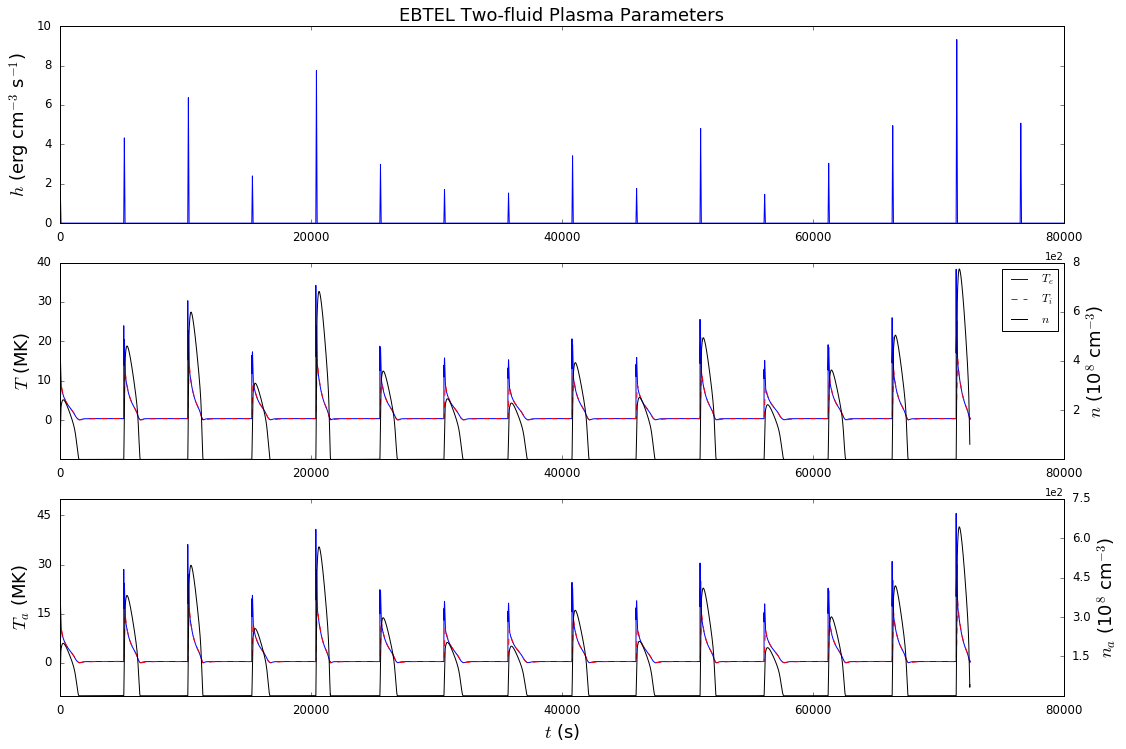

In [185]:
plotter=ebp.Plotter(parent_dir=config_printer.root_dir,child='const_heating_rate_testing')
plotter.plot_params()

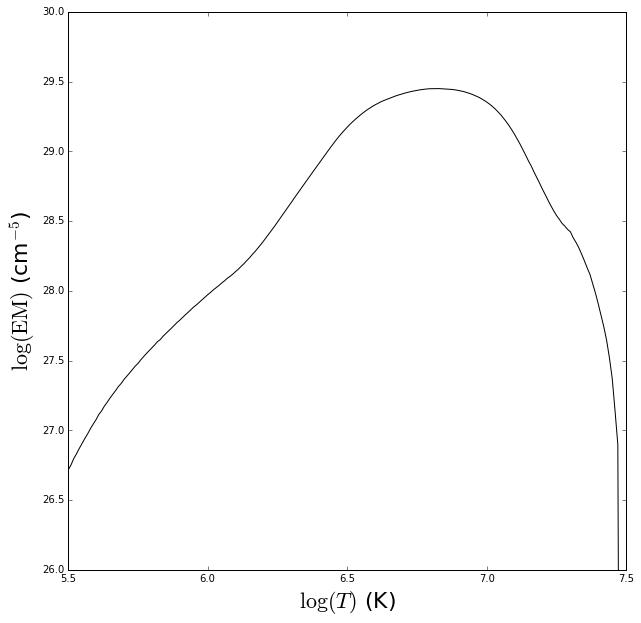

In [186]:
fig=plt.figure(figsize=(10,10))
ax = fig.gca()
ax.plot(plotter.temp_dem,plotter.em_cor,'k')
ax.set_xlim([5.5,7.5])
ax.set_ylim([26,30])
ax.set_xlabel(r'$\log (T)$ (K)',fontsize=22)
ax.set_ylabel(r'$\log(\mathrm{EM})$ (cm$^{-5}$)',fontsize=22)
plt.show()

In [187]:
np.argmax(plotter.em_cor[np.where((np.isinf(plotter.em_cor)==False) & (np.isnan(plotter.em_cor)==False))[0]])

208

In [188]:
plotter.temp_dem[np.where((np.isinf(plotter.em_cor)==False) & (np.isnan(plotter.em_cor)==False))[0]][208]

6.8200000000000003

## Changing distributions: from $Q$ to $H$

Now, instead of choosing $q$ from a distribution $\mathcal{P}_Q$ with bounds $[q_a,q_b]$, where $q_b=\delta q_a$, we want to instead choose $h$ from a distribution $\mathcal{P}_H$ with bounds $[h_a,h_b]$ such that $h_a = 2q_a/\tau A_hL$ and $h_b=\delta h_a=2q_b/\tau A_hL$.

In [189]:
wait_time_distributions = []
alphas = [-1.5,-2.0,-2.5]
const['loop_length'] = 120.0e+8
hn_target = time_averaged_heating_rate(const['loop_length'],const['tpeak'])
for a in alphas:
    wait_time_distributions_temp = []
    for tw in t_wait:
        #calculate number of events
        n = int(np.ceil(const['total_time']/(const['tau'] + tw)))
        #calculate bounds
        coeff = qmin_coefficient(const['delta'],a)
        a0 = coeff*time_averaged_heating_rate(const['loop_length'],const['tpeak'])*const['loop_length']*const['area']*(const['tau'] + tw)
        #convert from q to heating rate--this would be done in config printer script
        a0 = 2.0*a0/(const['loop_length']*const['area']*const['tau'])
        a1 = a0*const['delta']
        #calculate the distribution
        wait_time_distributions_temp.append(pl_dist(a0,a1,a,np.random.rand(n)))
    wait_time_distributions.append(wait_time_distributions_temp)

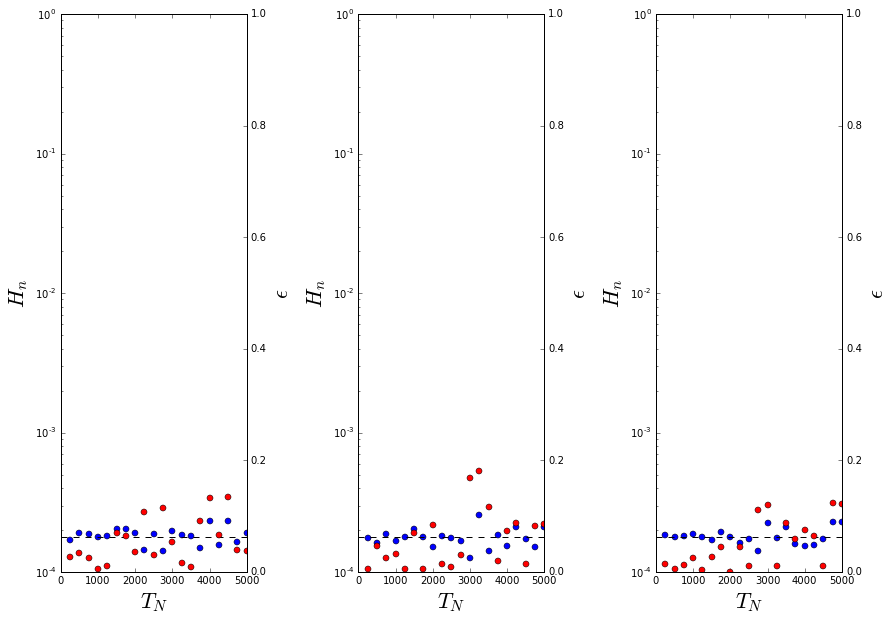

In [190]:
fig,ax = plt.subplots(1,len(alphas),figsize=(14,10))
plt.subplots_adjust(wspace=0.6)
for i in range(len(alphas)):
    error_axis = ax[i].twinx()
    for j in range(len(t_wait)):
        hn_tw = const['tau']/2.0*np.sum(wait_time_distributions[i][j])/const['total_time']
        ax[i].plot(t_wait[j],hn_tw,'bo')
        error_axis.plot(t_wait[j],np.fabs(hn_tw - hn_target)/np.fabs(hn_tw + hn_target),'ro')
    ax[i].axhline(y=hn_target,color='k',linestyle='--')
    ax[i].set_xlabel(r'$T_N$',fontsize=22)
    ax[i].set_ylabel(r'$H_n$',fontsize=22)
    error_axis.set_ylabel(r'$\epsilon$',fontsize=22)
    ax[i].set_ylim([0.0001,1.0])
    error_axis.set_ylim([0,1])
    ax[i].set_yscale('log')